## Analysis for resolution study

We ran simulations of the same 3x3 neighborhood with no buffer and a continuous source using `main.py -config ../../configs/config.yaml -res $res -idx 0`.

The sim states and field information are located on wopr in `/home/agkgd4/Documents/data/meep_studies/resolution_study`, but can be re-run on any machine using the command above.

Here, we visualize the fields from each simulation to determine the best resolution for this simulation.

In [1]:
import numpy as np
import os
import sys
import yaml
import matplotlib.pyplot as plt
import cv2

from helpers import get_colors, get_raw_data, get_slice, get_components, get_min_and_max, get_norm_fields, plot_fields

sys.path.append("../..")
from utils.general import load_config, parse_args

Using MPI version 3.1, 1 processes


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
root = "/develop/data/meep_studies/resolution_study"

all_resolutions = list(range(30, 111, 5))
all_resolutions.extend([20, 120])
all_resolutions.sort()
all_minima, all_maxima = [], []
components = {}

In [3]:
for resolution in all_resolutions:
    params, eps_data, ex_data, ey_data, ez_data = get_raw_data(resolution, root)
    slice = get_slice(params, eps_data, ex_data, ey_data, ez_data) # this gives us the location of the slice we want to observe
    x, y, z = get_components(slice, ex_data, ey_data, ez_data) # get x, y, and z componenets fo the fields at the specified slice
    min_val, max_val = get_min_and_max(x, y, z)
    all_minima.append(min_val)
    all_maxima.append(max_val)

    if resolution not in components:
        components[resolution] = {}
    components[resolution]['ex'] = x
    components[resolution]['ey'] = y
    components[resolution]['ez'] = z

### First, we locate a single slice of fields (at lambda/2). Then we get the x, y, and z components of the field at that slice. We find the min and max of the fields so we can normalize each field.

### Looking at the min and max across simulations, we plot extrema vs. resolution. When the curves begin to flatten, or converge around a point, we can conclude that increasing resolution does not give us better fidelity.

In [4]:
all_minima = np.asarray(all_minima)
all_maxima = np.asarray(all_maxima)

global_min = np.min(all_minima)
global_max = np.max(all_maxima)

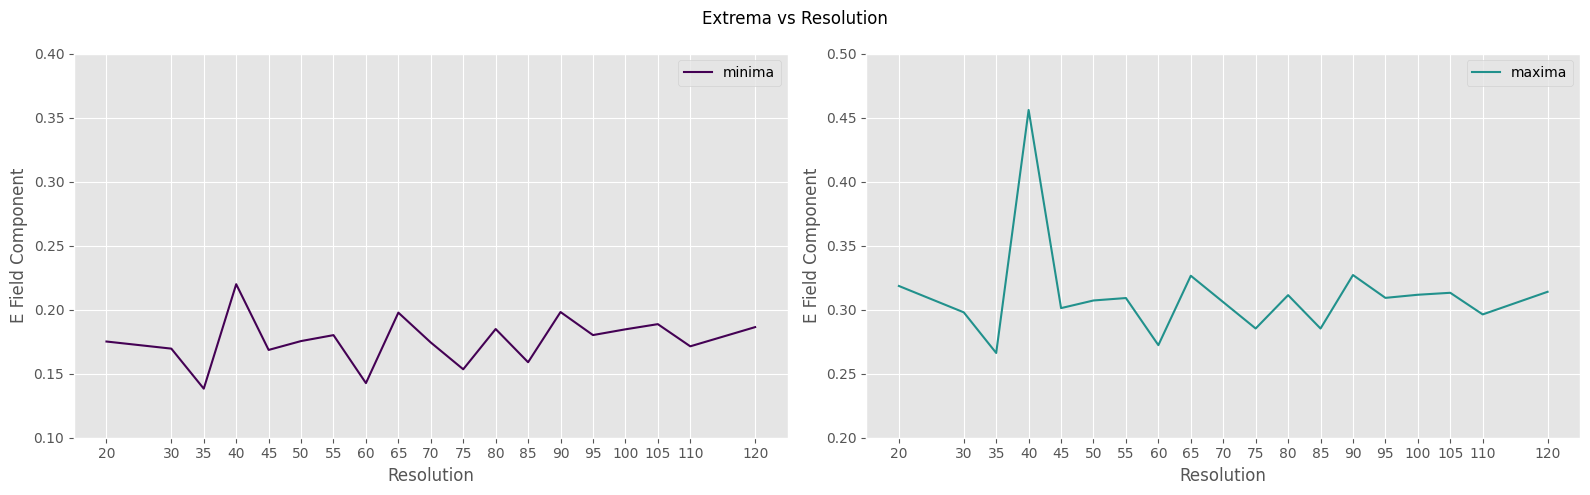

In [5]:
colors = get_colors(2)
plt.style.use("ggplot")

fig, ax = plt.subplots(1, 2, figsize=(16,5))
plt.suptitle("Extrema vs Resolution")
ax[0].plot(all_resolutions, np.abs(all_minima), c = colors[0], label='minima')
ax[1].plot(all_resolutions, all_maxima, c = colors[1], label='maxima')
ax[1].set_ylim(0.2,0.5)
ax[0].set_ylim(0.1, 0.4)

for axs in ax:
    axs.set_xticks(all_resolutions)
    axs.set_xlabel("Resolution")
    axs.set_ylabel("E Field Component")
    axs.legend()

plt.tight_layout()

### It looks like the fields are beginning to converge around resolution 70-80. To confirm this, we'll use our global min and max to normalize the fields across each other and plot them:

/develop/code/general_3x3/related_materials/resolution_study/helpers.py:191: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


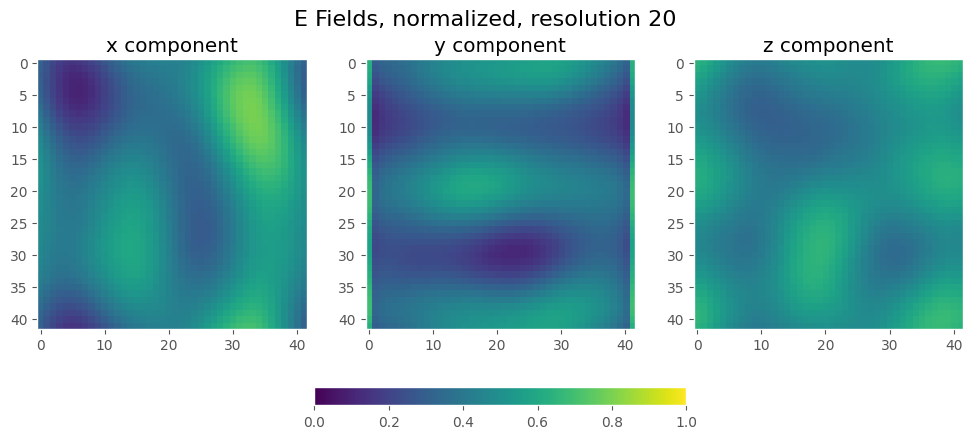

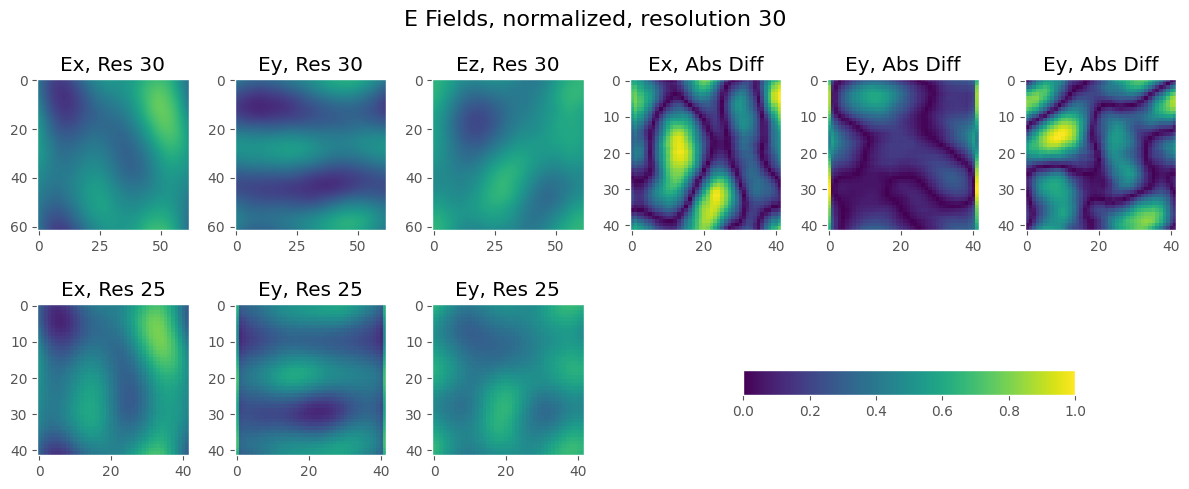

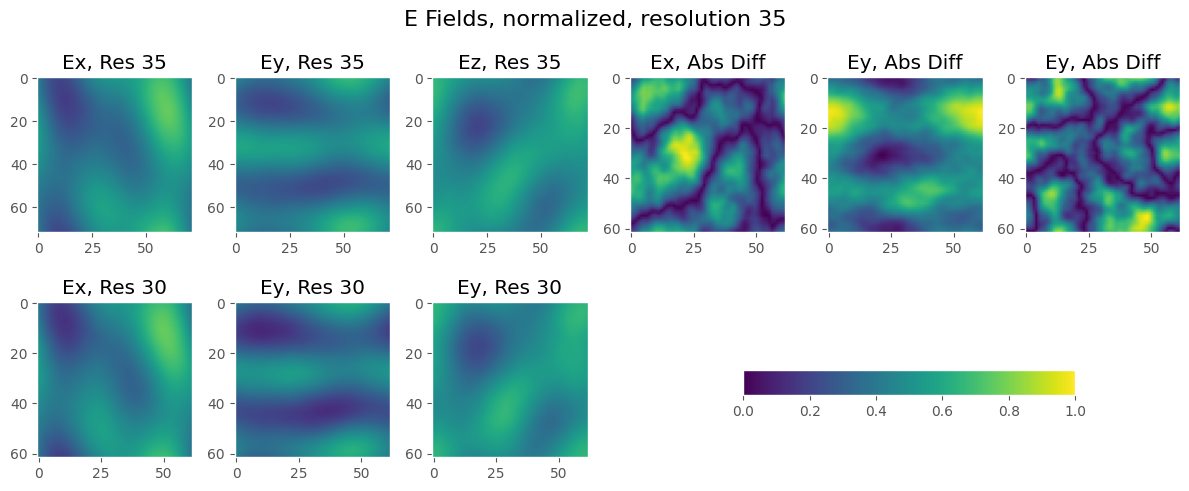

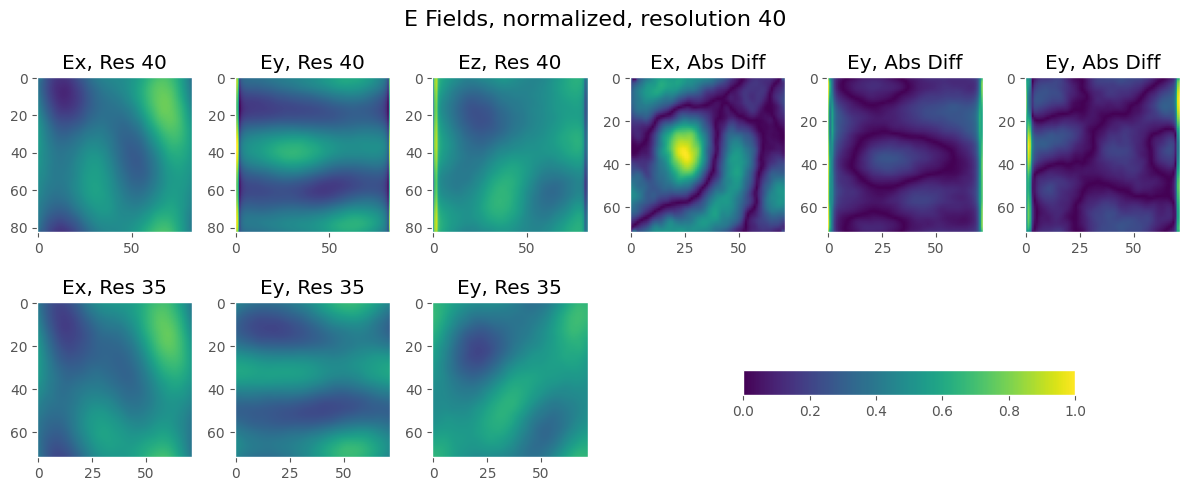

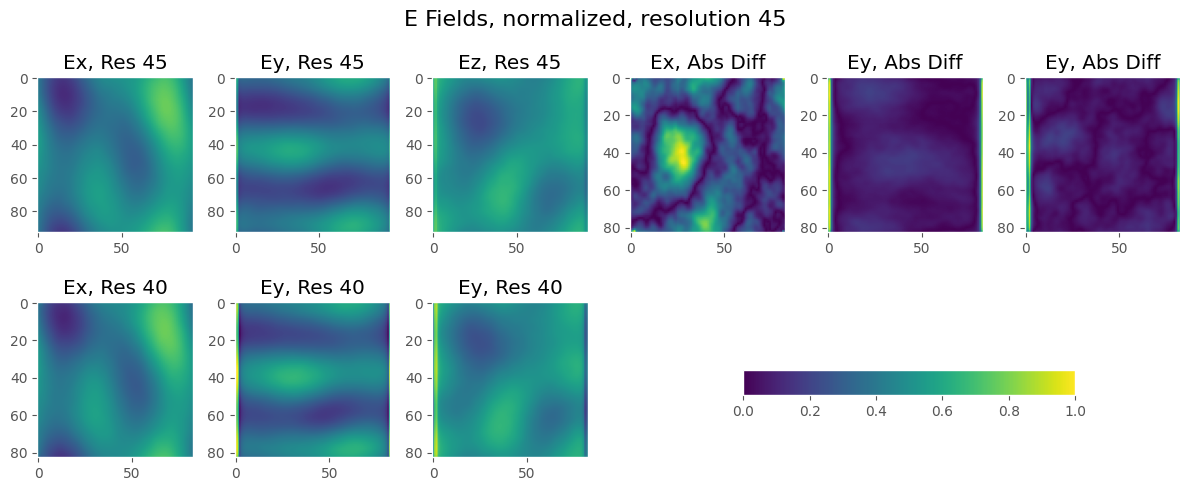

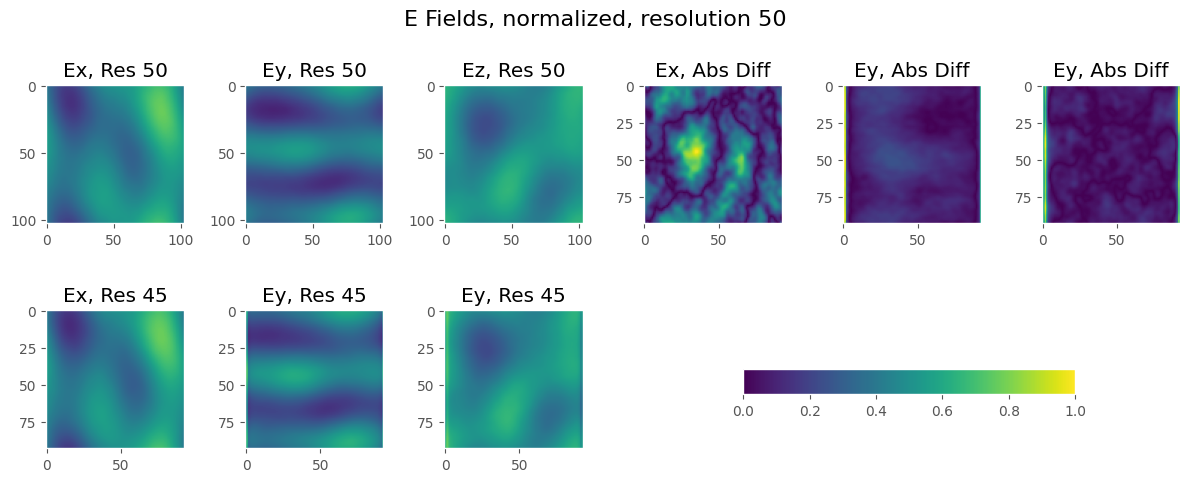

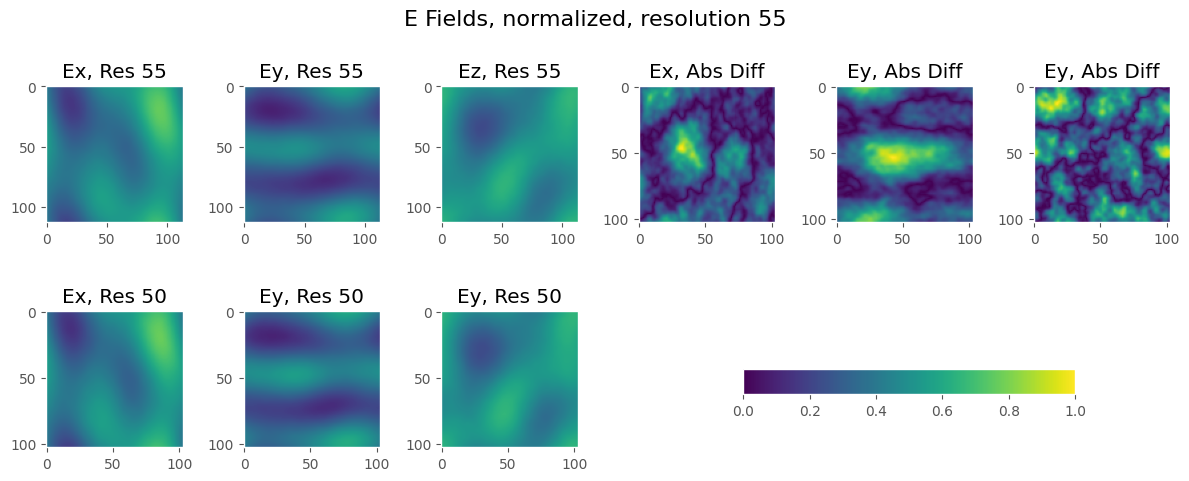

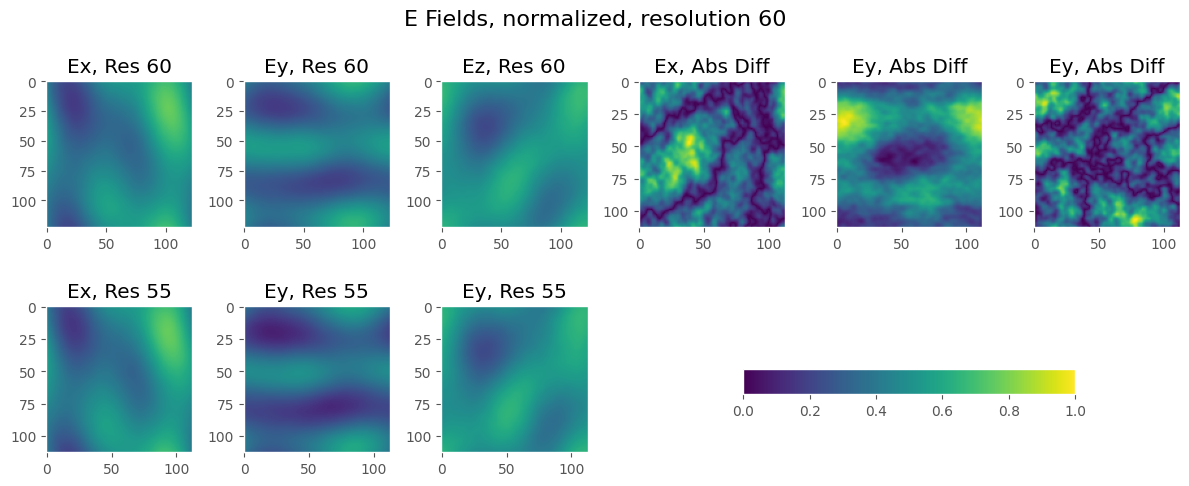

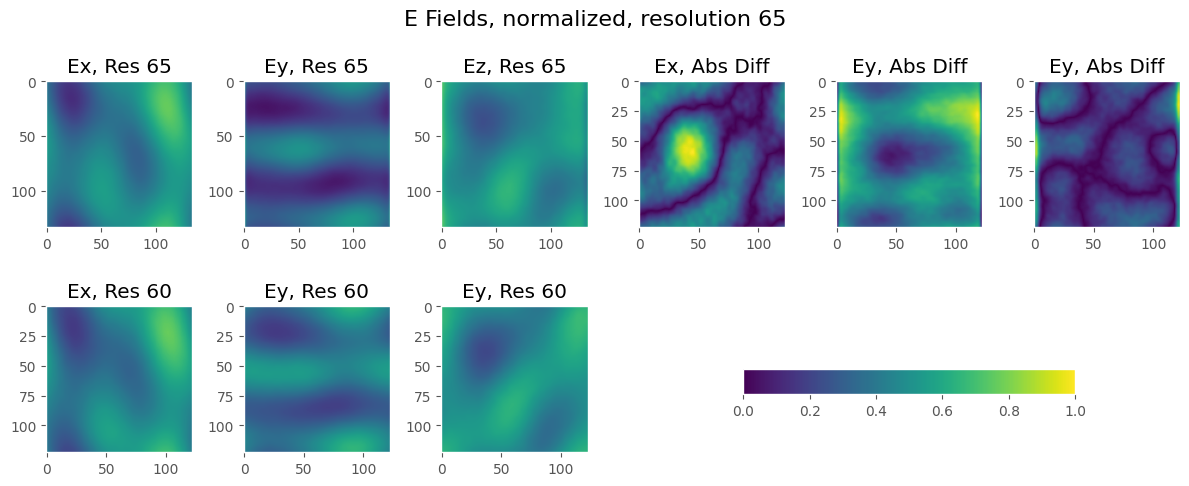

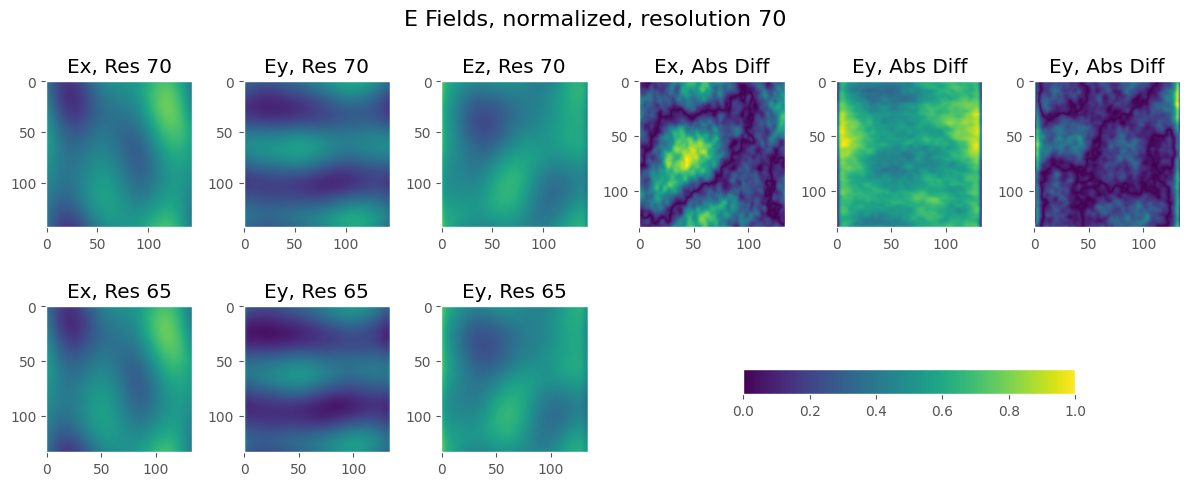

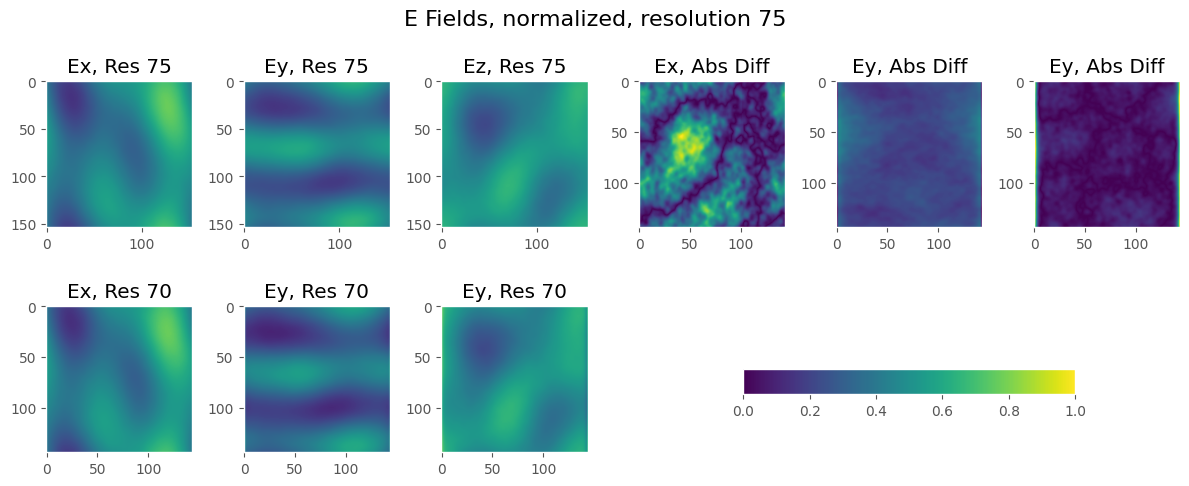

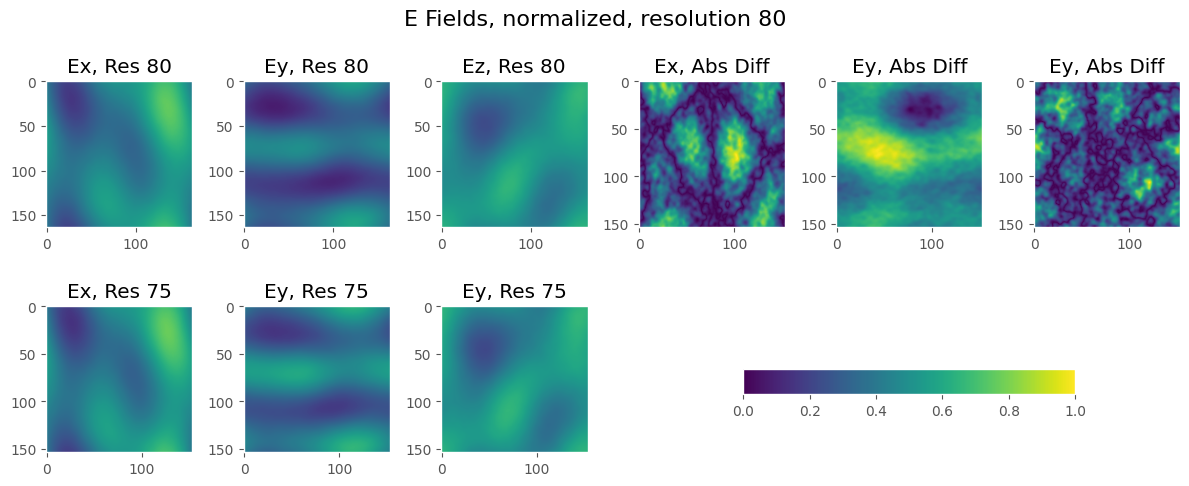

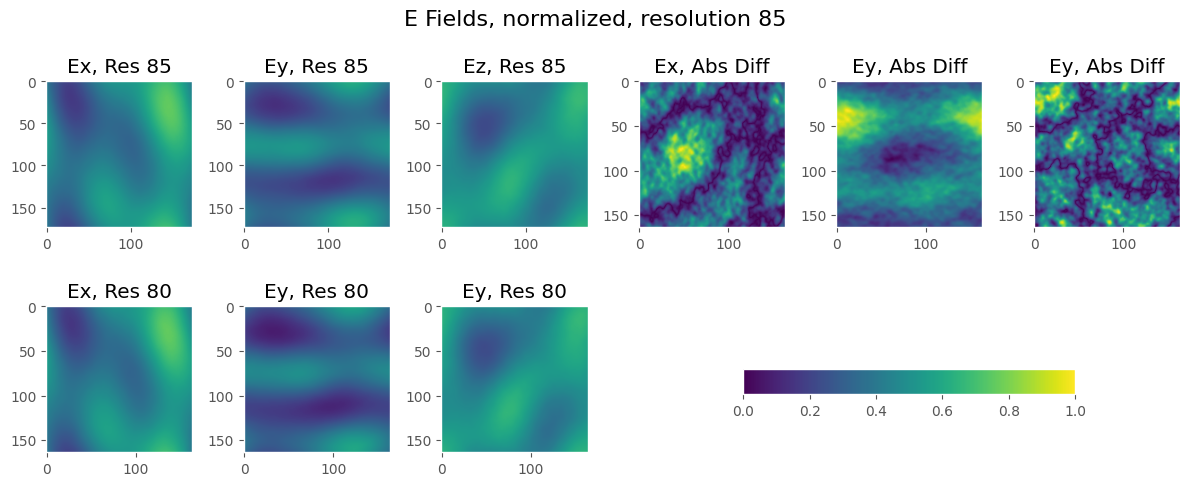

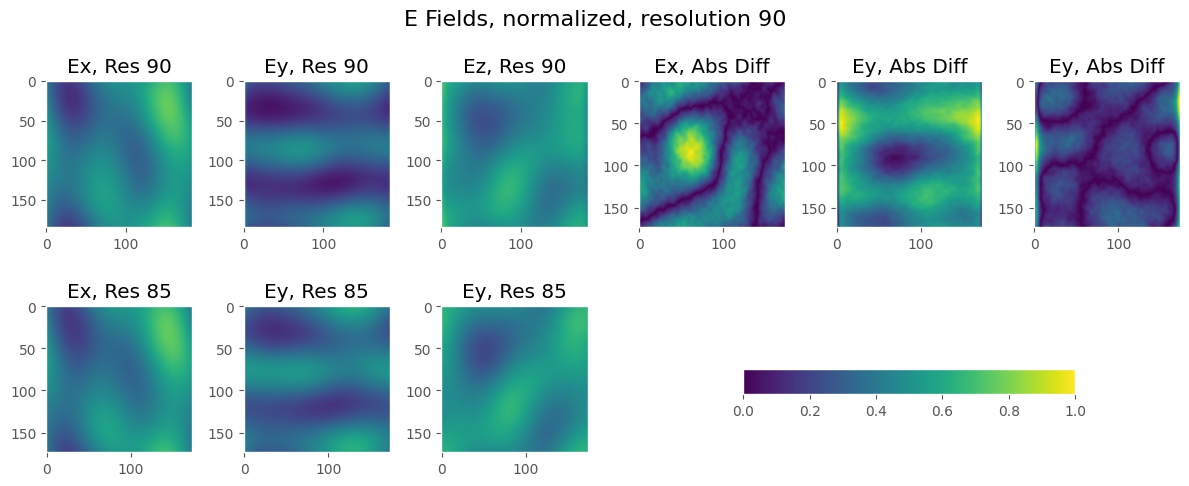

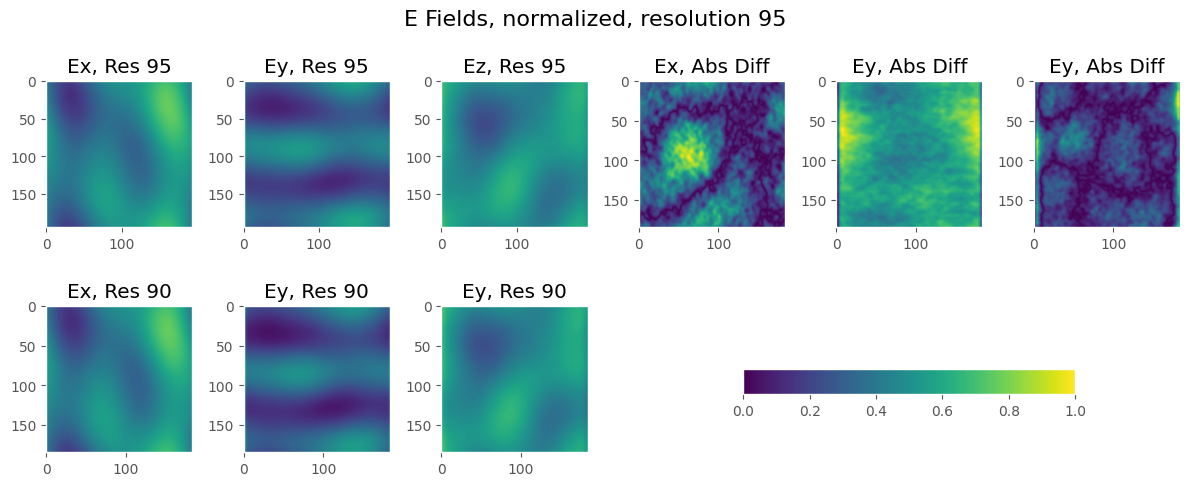

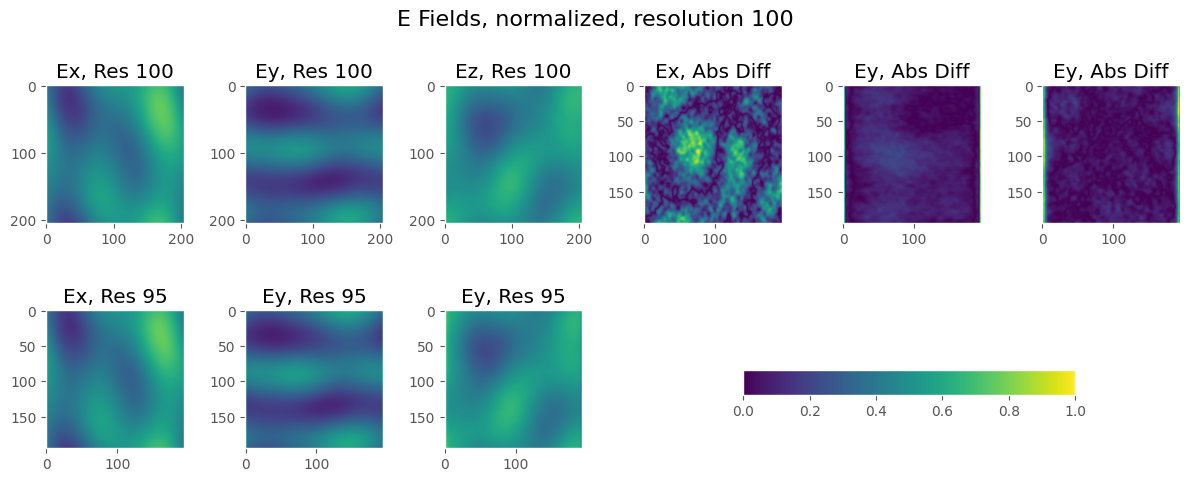

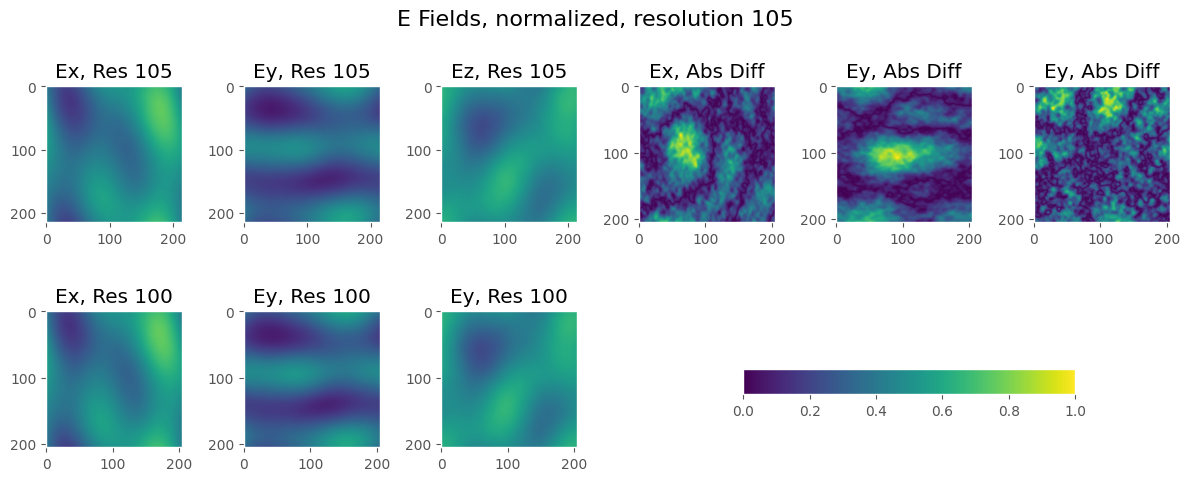

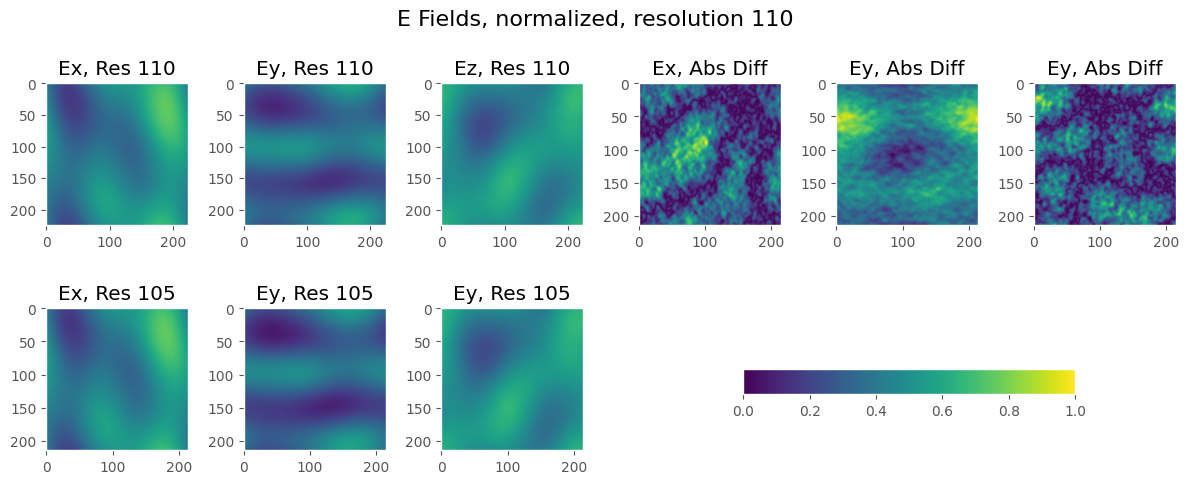

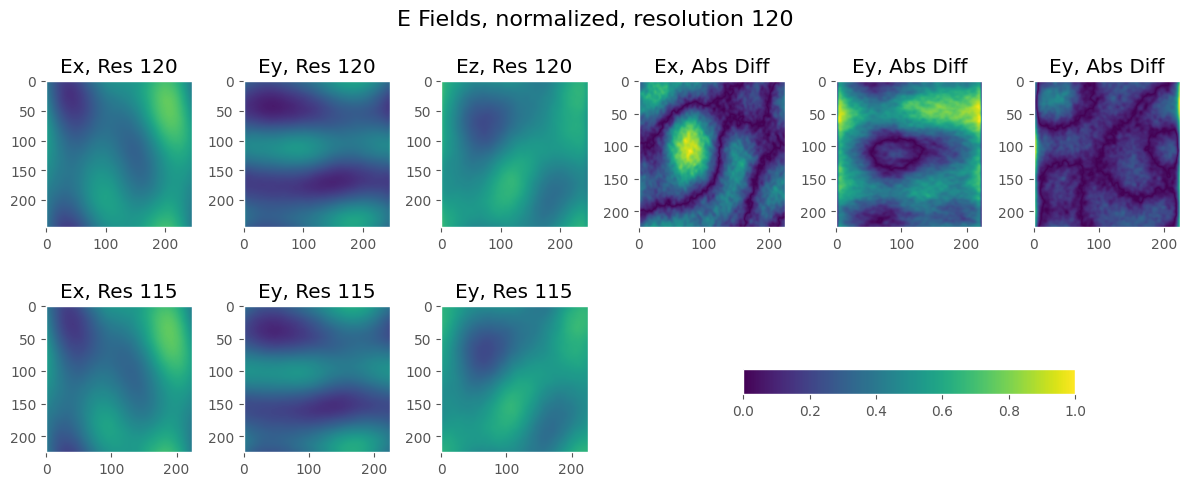

In [6]:
prior = None
for resolution in all_resolutions:
    ex_norm, ey_norm, ez_norm = get_norm_fields(components[resolution]['ex'], components[resolution]['ey'], components[resolution]['ez'], global_min, global_max)
    
    if resolution > all_resolutions[0]:
        ex_norm_minus1, ey_norm_minus1, ez_norm_minus1 = get_norm_fields(components[prior]['ex'], components[prior]['ey'], components[prior]['ez'], global_min, global_max)
        plot_fields(ex_norm, ey_norm, ez_norm, resolution, prior, ex_norm_minus1, ey_norm_minus1, ez_norm_minus1)
    else:
        plot_fields(ex_norm, ey_norm, ez_norm, resolution)
        
    prior = resolution # store the resolution value so we can use it to get ex_norm_minus1, etc. in the next iteration
                  